In [1]:
import math
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import random as rd
import tqdm.notebook as tq

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import utils
import utils_cl

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook
%load_ext autoreload

In [2]:
summary_df = pd.read_csv("dataset/summary.csv", index_col='TIME', parse_dates=['TIME'])
summary_df.drop(['MILESTONE_IMPORT_KWH', 'IMPORT_KWH_SHIFT1'], axis=1, inplace = True)

In [3]:
# Get rid of 4 last months
summary_df = summary_df[summary_df.index < '2018-04-1']

In [4]:
#summary_df.shape
#len(summary_df[summary_df['CONSUMPTION'] == 0]['CONSUMPTION'])

In [5]:
summary_df.tail(3)

,MA_DIEMDO,IS_FRAUD,CONSUMPTION
TIME,,,
2018-03-31 06:00:00,PP09000907514001,True,0.159324
2018-03-31 12:00:00,PP09000907514001,True,0.158758
2018-03-31 18:00:00,PP09000907514001,True,0.141255


In [6]:
summary_df.fillna(method='bfill', inplace = True)

In [7]:
summary_df['START_WEEKDAY'] = summary_df.index.to_period('W').start_time

In [8]:
summary_df = summary_df[summary_df['START_WEEKDAY'] != '2016-12-26']
summary_df = summary_df[summary_df['START_WEEKDAY'] != '2018-03-26']

In [9]:
print(summary_df.shape)
summary_df.head()

(1866893, 4)


,MA_DIEMDO,IS_FRAUD,CONSUMPTION,START_WEEKDAY
TIME,,,,
2017-01-02 00:00:00,PP01000100340001,False,1.071990,2017-01-02
2017-01-02 06:00:00,PP01000100340001,False,1.071990,2017-01-02
2017-01-02 12:00:00,PP01000100340001,False,0.950588,2017-01-02
2017-01-02 18:00:00,PP01000100340001,False,1.272025,2017-01-02
2017-01-03 00:00:00,PP01000100340001,False,0.521183,2017-01-02


In [10]:
#Get rid of sample with comsumption value < 0 
#summary_df = summary_df[summary_df['CONSUMPTION'] <= 0]

In [11]:
list_mdd = list(set(summary_df['MA_DIEMDO']))
list_sw = list(set(summary_df['START_WEEKDAY']))

In [12]:
summary_df2 = summary_df.groupby(['MA_DIEMDO', 'START_WEEKDAY'])['CONSUMPTION'].apply(list)

In [13]:
summary_df2 = pd.DataFrame(summary_df2)
summary_df2.reset_index(inplace = True)

In [14]:
print(summary_df2.shape)
summary_df2.head()

(66763, 3)


,MA_DIEMDO,START_WEEKDAY,CONSUMPTION
0,PP01000100340001,2017-01-02,"[1.0719898562762542, 1.0719898562762546, 0.950..."
1,PP01000100340001,2017-01-09,"[0.7636725935951071, 0.7636725935951034, 0.763..."
2,PP01000100340001,2017-01-16,"[0.5069982159723025, 0.5069982159723097, 0.897..."
3,PP01000100340001,2017-01-23,"[0.6750177034609237, 0.6750177034609237, 1.109..."
4,PP01000100340001,2017-01-30,"[0.8117496633248749, 0.8117496633248464, 0.903..."


In [15]:
from tqdm import tqdm
for ind in tqdm(range(summary_df2.shape[0])):
    len_list_consumption = len(list(summary_df2[summary_df2.index == ind ]['CONSUMPTION'])[0])
    if len_list_consumption != 28 :
        summary_df2.drop(ind , inplace=True)


100%|██████████████████████████████████████████████████████████████████████████| 66763/66763 [00:44<00:00, 1486.43it/s]


In [16]:
print(summary_df2.shape)

(66543, 3)


In [17]:
list_col = ['TIME_' + str(i + 1) for i in range(28)]
summary_df2[list_col] = pd.DataFrame(summary_df2.CONSUMPTION.tolist(), index= summary_df2.index)
summary_df2.drop('CONSUMPTION', axis = 1, inplace = True)

In [18]:
summary_df2['IS_FRAUD'] = False

In [19]:
summary_df2.head()

,MA_DIEMDO,START_WEEKDAY,TIME_1,TIME_2,TIME_3,TIME_4,TIME_5,TIME_6,TIME_7,TIME_8,...,TIME_20,TIME_21,TIME_22,TIME_23,TIME_24,TIME_25,TIME_26,TIME_27,TIME_28,IS_FRAUD
0,PP01000100340001,2017-01-02,1.071990,1.071990,0.950588,1.272025,0.521183,0.521183,1.371933,1.025683,...,0.952474,0.503377,0.503377,0.632368,0.632368,0.428766,0.428766,1.130079,0.787332,False
1,PP01000100340001,2017-01-09,0.763673,0.763673,0.763673,0.763673,0.763673,0.763673,1.522158,0.876736,...,0.880946,0.597618,0.597618,0.867206,2.178154,1.050095,1.050095,0.223318,0.762987,False
2,PP01000100340001,2017-01-16,0.506998,0.506998,0.897201,0.767088,0.728221,0.728221,0.813047,0.746418,...,0.955296,0.599409,0.599409,0.888135,1.177667,0.640047,0.640047,1.571213,0.766795,False
3,PP01000100340001,2017-01-23,0.675018,0.675018,1.109636,1.117002,0.570628,0.570628,1.406446,0.836815,...,0.534937,0.986200,0.986200,1.002349,1.075476,0.967791,0.967791,1.493868,0.626669,False
4,PP01000100340001,2017-01-30,0.811750,0.811750,0.903721,1.238893,0.768862,0.768862,3.122375,1.813596,...,0.782079,0.618889,0.618889,1.766039,1.025119,0.935988,0.935988,1.405387,1.235285,False


In [20]:
fraud_milestones = [('PP07000684209001','2017-12-29'),
 ('PP07000670259001','2017-01-03'),
 ('PP07000693227001','2017-08-14'),
 ('PP07000713473001','2017-04-12'),
 ('PP07000662970001','2017-03-02'),
 ('PP07000700839001','2017-05-23'),
 ('PP07000668984001','2017-08-24'),
 ('PP07000683751001','2017-10-25'),
 ('PP07000683750001','2017-10-25'),
 ('PP07000613734001','2017-03-24'),
 ('PP07000673219001','2017-04-24'),
 ('PP07000682085001','2017-10-27'),
 ('PP07000613618001','2017-11-29'),
 ('PP07000600208001','2017-10-05'),
 ('PP07000600209001','2017-10-05'),
 ('PP07000678169001','2017-07-06'),
 ('PP01000134773001','2017-12-12'),
 ('PP01000624985001','2017-12-28'),
 ('PP01000621525001','2017-01-11'),
 ('PP01000117448001','2017-04-14'),
 ('PP01000117849001','2017-10-25'),
 ('PP01000110500001','2017-03-27'),
 ("PP01000103859001","2017-10-30"),
 ('PP01000131431001','2017-04-03'),
 ("PP01000103454001",'2017-08-03'),
 ('PP01000101145001','2017-03-06'),
 ('PP01000140094001','2017-01-09'),
 ('PP01000101975001','2017-02-07'),
 ('PP03000810040001','2017-08-12'),
 ('PP03000832565001','2017-06-13'),
 ('PP03000806717001','2017-07-12'),
 ('PP03000902373001','2017-07-17'),
 ('PP03000809863001','2017-12-19'),
 ('PP03000882852001','2017-12-21'),
 ('PP03000902981001','2017-04-21'),
 ('PP03000804097001','2017-06-24'),
 ('PP03000805922001','2017-09-25'),
 ('PP03000804137001','2017-10-30'),
 ('PP03000904351001','2017-03-28'),
 ('PP03000898466001','2017-06-29'),
 ('PP05000989390001','2017-05-02'),
 ('PP05000948327001','2017-08-10'),
 ('PP05000977900001','2017-01-13'),
 ('PP05000501075001','2017-01-13'),
 ('PP05000501411001','2017-10-13'),
 ('PP05000524904001','2017-04-13'),
 ('PP05000951373001','2017-04-14'),
 ('PP05000967512001','2017-03-15'),
 ('PP05000960339001','2017-03-15'),
 ('PP05000515674001','2017-04-18'),
 ('PP05000967753001','2017-07-20'),
 ('PP05000944240001','2017-05-22'),
 ('PP05000504291001','2017-04-21'),
 ('PP05000968892001','2017-05-22'),
 ('PP05000961578001','2017-05-22'),
 ('PP05000953931001','2017-11-23'),
 ('PP05000502843001','2017-02-24'),
 ('PP05000941329001','2017-11-25'),
 ('PP05000509756001','2017-08-30'),
 ('PP05000524362001','2017-01-04'),
 ('PP05000516894001','2017-04-05'),
 ('PP05000522325001',"2017-12-06"),
 ('PP05000517007001','2017-08-07'),
 ('PP05000515078001','2017-03-09'),
 ('PP05000991348001','2017-05-09'),
 ('PP09000810551001','2017-08-11'),
 ('PP09000884920001','2017-04-11'),
 ('PP09000802199001','2017-09-11'),
 ('PP09000811262001','2017-02-13'),
 ('PP09000120555001','2017-04-17'),
 ('PP09000890287001','2017-02-20'),
 ('PP09000808752001','2017-12-21'),
 ('PP09000817228001','2017-10-24'),
 ('PP09000907245001','2017-11-24'),
 ('PP09000821975001','2017-10-28'),
 ('PP09000837585001','2017-11-28'),
 ('PP09000808816001','2017-12-28'),
 ('PP09000808816001','2017-04-29'),
 ('PP09000892588001','2017-10-31'),
 ('PP09000894390001','2017-10-31'),
 ("PP09000894706001","2017-12-08") 
]

In [21]:
def get_start_week(str_date):
    return pd.Timestamp(str_date).to_period('W').start_time

summary_df3 = summary_df2

for _pair in tqdm(fraud_milestones):
    mdd = _pair[0]
    str_date = _pair[1]
    summary_df3['IS_FRAUD'].loc[(summary_df3['MA_DIEMDO'] == mdd) & (summary_df3['START_WEEKDAY'] <= get_start_week(str_date))] = True

100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 111.43it/s]


In [22]:
summary_df3.to_csv("dataset/weekly_applied_fraud_milestones_2.csv")

In [23]:
print(summary_df3.shape)
summary_df3.head()

(66543, 31)


,MA_DIEMDO,START_WEEKDAY,TIME_1,TIME_2,TIME_3,TIME_4,TIME_5,TIME_6,TIME_7,TIME_8,...,TIME_20,TIME_21,TIME_22,TIME_23,TIME_24,TIME_25,TIME_26,TIME_27,TIME_28,IS_FRAUD
0,PP01000100340001,2017-01-02,1.071990,1.071990,0.950588,1.272025,0.521183,0.521183,1.371933,1.025683,...,0.952474,0.503377,0.503377,0.632368,0.632368,0.428766,0.428766,1.130079,0.787332,False
1,PP01000100340001,2017-01-09,0.763673,0.763673,0.763673,0.763673,0.763673,0.763673,1.522158,0.876736,...,0.880946,0.597618,0.597618,0.867206,2.178154,1.050095,1.050095,0.223318,0.762987,False
2,PP01000100340001,2017-01-16,0.506998,0.506998,0.897201,0.767088,0.728221,0.728221,0.813047,0.746418,...,0.955296,0.599409,0.599409,0.888135,1.177667,0.640047,0.640047,1.571213,0.766795,False
3,PP01000100340001,2017-01-23,0.675018,0.675018,1.109636,1.117002,0.570628,0.570628,1.406446,0.836815,...,0.534937,0.986200,0.986200,1.002349,1.075476,0.967791,0.967791,1.493868,0.626669,False
4,PP01000100340001,2017-01-30,0.811750,0.811750,0.903721,1.238893,0.768862,0.768862,3.122375,1.813596,...,0.782079,0.618889,0.618889,1.766039,1.025119,0.935988,0.935988,1.405387,1.235285,False


# 2. Clustering

In [24]:
# Scale Data
summary_df3 = summary_df3.sort_values(by=["IS_FRAUD"])
normal_df = summary_df3[summary_df3['IS_FRAUD'] == False]
fraud_df = summary_df3[summary_df3['IS_FRAUD'] == True]

In [25]:
print("Normal : ", normal_df.shape[0])
print("Fraud : ", fraud_df.shape[0])

Normal :  64922
Fraud :  1621


In [26]:
X = summary_df3.iloc[:, 2:-1].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_normalized = normalize(X_scaled, axis=1)
X_normalized = pd.DataFrame(X_normalized)

X_normalized = X_scaled

n_normal = normal_df.shape[0]
X_normal = X_normalized.iloc[:n_normal, :]
X_fraud = X_normalized.iloc[n_normal:, :]

In [27]:
# Split Normal data into Train & Test set
X_normal_train = X_normal.sample(frac = 0.5, random_state = 0)
X_normal_test = X_normal.drop(X_normal_train.index)

In [115]:
from sklearn.cluster import KMeans

distance_used = utils_cl.distance_ED
cluster_number  = 3
n_iters = 500

km = KMeans(
    n_clusters=cluster_number, init='random',
    n_init=10, max_iter=n_iters, 
    tol=1e-04, random_state=100
)

y_km = km.fit_predict(X_normal_train)
centroids = km.cluster_centers_

In [116]:
count_cluster = [0]*cluster_number
for i in y_km:
    count_cluster[i] += 1
for i in range(cluster_number):
    print("Cluster {0} : {1}".format(i + 1, count_cluster[i] ))

Cluster 1 : 4997
Cluster 2 : 26960
Cluster 3 : 504


In [117]:
dict_DC = {}
for i in range(cluster_number):
    dict_DC[i+1] = []
    
for i, j in enumerate(y_km):
    dict_DC[j+1].append(distance_used(centroids[j], X_normal_train.iloc[i, :]))

<IPython.core.display.Javascript object>


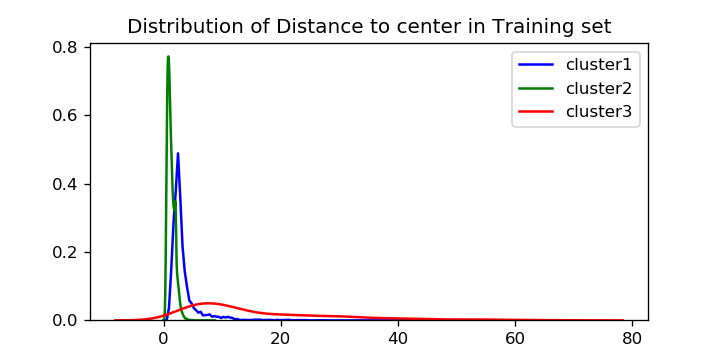

In [118]:
def distribution_plotting(cluster_number, is_print_individual = False):
    if cluster_number > 7:
        colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), cluster_number, replace = True)
    else :
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    if is_print_individual : 
        for i in range(cluster_number):
            plt.figure(figsize = (4, 2), dpi = 120)
            sns.distplot(dict_DC[i+1])
            plt.title("Distribution of Distance to Center"  + str(i+1))
        
    plt.figure(figsize = (6, 3), dpi = 120)
    for i in range(cluster_number):
        sns.kdeplot(dict_DC[i+1], label="cluster" + str(i+1), color = colors[i])
    plt.legend();
    plt.title("Distribution of Distance to center in Training set")
distribution_plotting(cluster_number, False)


## . Pred

In [120]:
average_radius = []
for j in range(cluster_number):
    average_radius.append(sum(dict_DC[j+1])/len(dict_DC[j+1]))

In [121]:
max_radius = []
for j in range(cluster_number):
    max_radius.append(max(dict_DC[j+1]))

In [122]:
quantile_radius = []
percentile = 0.6
for j in range(cluster_number):
    quantile_radius.append(pd.DataFrame(dict_DC[j+1]).quantile(percentile, axis = 0)[0])

In [123]:
average_radius

[3.3672229791996684, 1.271385926898339, 16.263792178941696]

In [124]:
max_radius

[48.63285337318243, 8.470148935753677, 67.77371967064914]

In [125]:
quantile_radius

[2.8239591052645583, 1.300781029427354, 13.782503088236945]

> **Cluster-3 co it samples va phan bo quanh Centroid khong deu -> Cluster bat thuong**

> **Neu de Cluster-3 la normal (voi radius cao) se anh huong den do chinh xac**

In [126]:
# Predicting 1
def test_mdd_fraud(test_mdd, thresh_hold_KM = 1.0):
    # ED_test2c        : distance from test_mdd to each center
    # distance_cent_th : cluster_radius

    ED_test2c = [distance_used(test_mdd, _cent) for _cent in centroids ]
    distance_cent_th = [_dis*thresh_hold_KM for _dis in quantile_radius]
    result_is_fraud = [ a < b for (a,b) in zip(distance_cent_th, ED_test2c)]
    return result_is_fraud


def prediction_result(test_set, thresh_KM = 1.0, cluster_abnormal = []):
    total_correct = 0
    N = test_set.shape[0]
    test_wrong = [0]*(cluster_number - len(cluster_abnormal))
    for i in range(N):
        try:
            test_mdd_i = test_set.iloc[i, :]
        except :
            print("Fail - ", i)
        test_mdd_fraud_res = test_mdd_fraud(test_mdd_i, thresh_KM)
        for i, j in enumerate(cluster_abnormal):
            del test_mdd_fraud_res[j-1-i]
        if sum(test_mdd_fraud_res) == (cluster_number - len(cluster_abnormal)) :
            total_correct += 1
        else :
            test_wrong = [ a + b for (a,b) in zip(test_wrong, test_mdd_fraud(test_mdd_i, thresh_KM))]
    print("Total fraud predicted      : ", total_correct )
    print("Total test samples         : ", N)
    print(total_correct/N)
    return test_wrong

In [127]:
# Predicting 2
def test_mdd_fraud_2(test_mdd, thresh_KM):
    ED_test2c = [distance_used(test_mdd, _cent) for _cent in centroids]
    distance_nearest = min(ED_test2c)
    cluster_nearest = ED_test2c.index(distance_nearest) + 1
    is_fraud = (distance_nearest > quantile_radius[cluster_nearest-1] * thresh_KM)
    return is_fraud

def prediction_result_2(test_set, thresh_KM = 1.0):
    total_fraud = 0
    N = test_set.shape[0]
    for i in range(N):
        test_mdd_i = test_set.iloc[i, :]
        test_mdd_fraud_res = test_mdd_fraud_2(test_mdd_i, thresh_KM)
        if test_mdd_fraud_res:
            total_fraud += 1
    print("Total fraud predicted      : ", total_fraud )
    print("Total test samples         : ", N)
    print(total_fraud/N)
    return 

In [128]:
thresh_KM = 1

test_set_fraud = X_fraud

cluster_abnormal = []

test_wrong = prediction_result_2(test_set_fraud, thresh_KM)

Total fraud predicted      :  1088
Total test samples         :  1621
0.6711906230721777


In [129]:
thresh_KM = 1

test_set_normal = X_normal_test

cluster_abnormal = []

test_wrong = prediction_result_2(test_set_normal, thresh_KM)

Total fraud predicted      :  12883
Total test samples         :  32461
0.39687625150180217


## .Pred 2

In [ ]:
# Clustering
pca = PCA(n_components=3)
X_principal = pca.fit_transform(X_normalized)

In [ ]:
from sklearn.cluster import DBSCAN
# DBSCAN
eps = 0.5
min_samples = 5
labels_1 = utils_cl._DBSCAN(X_principal, eps, min_samples)

In [ ]:
from collections import Counter
c = Counter(labels_1) 
print(c)

In [ ]:
X_principal

In [ ]:
X_normalized